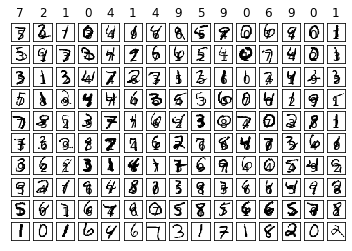

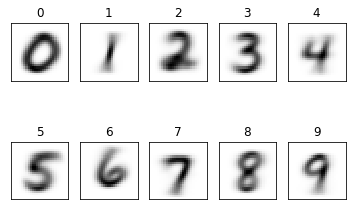

In [1]:
  import matplotlib.pyplot as plt
  import numpy as np

  file_data   = "mnist.csv"
  handle_file = open(file_data, "r")
  data        = handle_file.readlines()
  handle_file.close()

  size_row    = 28    # height of the image
  size_col    = 28    # width of the image

  num_image   = len(data)
  count       = 0     # count for the number of images

  #
  # normalize the values of the input data to be [0, 1]
  #
  def normalize(data):

      data_normalized = (data - min(data)) / (max(data) - min(data))

      return(data_normalized)

  #
  # example of distance function between two vectors x and y
  #
  def distance(x, y):

      d = (x - y) ** 2
      s = np.sum(d)
      # r = np.sqrt(s)

      return(s)

  #
  # make a matrix each column of which represents an images in a vector form
  #
  list_image  = np.empty((size_row * size_col, num_image), dtype=float)
  list_label  = np.empty(num_image, dtype=int)

  for line in data:

      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      list_label[count]       = label
      list_image[:, count]    = im_vector

      count += 1

  #
  # plot first 150 images out of 10,000 with their labels
  #
  f1 = plt.figure(1)

  for i in range(150):

      label       = list_label[i]
      im_vector   = list_image[:, i]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(10, 15, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)


  #plt.show()

  #
  # plot the average image of all the images for each digit
  #
  f2 = plt.figure(2)

  im_average  = np.zeros((size_row * size_col, 10), dtype=float)
  im_count    = np.zeros(10, dtype=int)

  for i in range(num_image):

      im_average[:, list_label[i]] += list_image[:, i]
      im_count[list_label[i]] += 1

  for i in range(10):

      im_average[:, i] /= im_count[i]

      plt.subplot(2, 5, i+1)
      plt.title(i)
      plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)

  plt.show()

In [2]:
import numba
print(numba.__version__)

0.48.0


In [20]:
from collections import OrderedDict

class Affine:

  def __init__(self, W):
    self.W = W
    self.x = None
    self.dW = None

  def forward(self, x):
    x = np.concatenate((np.expand_dims(np.ones(x.shape[0]), axis = 1), x), axis = 1)
    self.x = x
    out = np.dot(x, self.W)
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T[:,1:])
    self.dW = np.dot(self.x.T, dout)
    return dx

class sigmoid:

  def __init__(self):
    self.out = None

  def forward(self,x):
      out = 1. / (1. + np.exp(-x))
      self.out = out
      return out

  def backward(self,dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class ThreeLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, rambda, std = 0.1):
        
        self.rambda = rambda
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size+1, hidden_size1)  # xavier
        self.params['W2'] = std * np.random.randn(hidden_size1+1, hidden_size2) 
        self.params['W3'] = std * np.random.randn(hidden_size2+1, output_size) 
        #np.concatenate((np.random.randn(input_size+1, hidden_size1).T, np.expand_dims(np.ones(hidden_size1), axis = 1)), axis = 1)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'])
        self.layers['sigmoid1'] = sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'])
        self.layers['sigmoid2'] = sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'])
        self.layers['sigmoid3'] = sigmoid()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    # x : 입력 데이터, t : 정답 레이블

    def loss(self, x, t, rambda):
        y = self.predict(x)

        t = np.int64(np.expand_dims(t, axis = 1))
        a = np.zeros((t.shape[0],10), dtype = int)
        for i in range(t.shape[0]):
          a[i,t[i]] = 1
        delta = 1e-7
        return -np.sum(a * np.log(y + delta) + (1-a) * np.log(1-y+delta)) / float(x.shape[0]) + rambda / 2 / x.shape[0] \
    * (np.sum(np.power(self.params['W1'], 2))+np.sum(np.power(self.params['W2'],2))+np.sum(np.power(self.params['W3'],2)))

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블

    def gradient(self, x, t, rambda):
 
        y = self.predict(x)
        t = np.int64(np.expand_dims(t, axis = 1))
        a = np.zeros((t.shape[0],10), dtype = int)
        for i in range(t.shape[0]):
          a[i,t[i]] = 1
        dout = y-a

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['W2'] = self.layers['Affine2'].dW
        grads['W3'] = self.layers['Affine3'].dW

        return grads

In [4]:
x_train = list_image[:, :1000].T
t_train = list_label[:1000]
x_test = list_image[:, 1000:].T
t_test = list_label[1000:]

In [36]:
network = ThreeLayerNet(input_size=784, hidden_size1=196, hidden_size2 = 49,output_size=10, rambda = 0.8)
iters_num = 10000
train_size = x_train.shape[0]
learning_rate = 0.001
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
decay = 0.001

for i in range(iters_num):
    
    grad = network.gradient(x_train, t_train, network.rambda) 
    for key in ('W1','W2','W3'):
        network.params[key] -= learning_rate * grad[key] + learning_rate * network.rambda / x_train.shape[0] * network.params[key]
    
    train_loss = network.loss(x_train, t_train, network.rambda)  
    test_loss = network.loss(x_test, t_test, network.rambda)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    if i % 10 == 0:
        learning_rate = learning_rate * 1/(1 + decay)
        print(train_loss, test_loss, train_acc, test_acc)
    if i > 1000:
        if train_loss_list[-1] > train_loss_list[-2]: #check convergence
            learning_rate = learning_rate * 1/(1 + decay)

4.149733513924596 3.5767477735193602 0.148 0.10811111111111112
3.8970560671786076 3.3257624748161816 0.114 0.09166666666666666
3.8904632674002353 3.3214572182154933 0.147 0.11588888888888889
3.8851567105316342 3.3171437186178507 0.167 0.13377777777777777
3.87979829753082 3.312376012227078 0.178 0.1458888888888889
3.874282269587505 3.3073550129650546 0.191 0.154
3.868544284758734 3.3021040826014305 0.198 0.162
3.8625174650290983 3.2965848830268345 0.205 0.17077777777777778
3.8561290313564935 3.2907390053953067 0.215 0.17644444444444443
3.8492987800530325 3.2844980006468023 0.233 0.18655555555555556
3.8419373527125407 3.277784704965247 0.246 0.1968888888888889
3.83394417489332 3.270512174846286 0.26 0.20877777777777778
3.825204993042904 3.2625817557723056 0.279 0.2238888888888889
3.815588912319686 3.2538805827866675 0.304 0.2361111111111111
3.8049448104813695 3.2442784892990963 0.311 0.24933333333333332
3.7930969652955797 3.2336241840780464 0.321 0.2598888888888889
3.779839680096533 3.22

1.4226108151438805 1.0289112006965455 0.952 0.864
1.419082382986109 1.0262694391020126 0.952 0.8643333333333333
1.415614463016527 1.0236846958153294 0.952 0.8644444444444445
1.4122055724534102 1.0211556964587696 0.953 0.8644444444444445
1.4088542779884792 1.0186812066965105 0.953 0.8645555555555555
1.405559193660157 1.0162600289441588 0.954 0.8645555555555555
1.4023189788067885 1.01389099921302 0.955 0.8648888888888889
1.3991323360956733 1.0115729841047525 0.955 0.8646666666666667
1.395998009625399 1.009304877972344 0.955 0.8648888888888889
1.3929147831003317 1.007085600263291 0.956 0.865
1.389881478077167 1.004914093060429 0.957 0.8653333333333333
1.3868969522841461 1.0027893188350578 0.957 0.8654444444444445
1.3839600980138982 1.0007102584257486 0.957 0.8657777777777778
1.381069840590925 0.9986759092544627 0.957 0.866
1.378225136914522 0.996685283789301 0.958 0.8662222222222222
1.3754249740775246 0.9947374082602876 0.96 0.8663333333333333
1.3726683680607612 0.9928313216310783 0.96 0.

1.2091513855318812 0.9026053605834707 0.983 0.8778888888888889
1.2085275434238092 0.9023065791256525 0.983 0.8781111111111111
1.207910757794596 0.9020099759257918 0.983 0.878
1.2073009207141587 0.9017154712359032 0.983 0.8778888888888889
1.2066979259954072 0.901422988000074 0.983 0.8776666666666667
1.2061016692654096 0.9011324521173509 0.984 0.8776666666666667
1.205512048035026 0.9008437927073911 0.984 0.8776666666666667
1.2049289617671042 0.9005569423776257 0.984 0.878
1.2043523119431734 0.9002718374906282 0.984 0.878
1.2037820021284675 0.8999884184302962 0.984 0.878
1.2032179380349681 0.8997066298653332 0.984 0.8777777777777778
1.2026600275820667 0.8994264210083677 0.984 0.8777777777777778
1.2021081809543577 0.8991477458688588 0.984 0.8776666666666667
1.2015623106560094 0.8988705634977345 0.984 0.8775555555555555
1.2010223315611137 0.8985948382214594 0.984 0.8777777777777778
1.200488160959405 0.8983205398629914 0.984 0.8776666666666667
1.199959718596728 0.8980476439468174 0.984 0.877

1.1666870840456927 0.8820069703485061 0.988 0.8805555555555555
1.1665685216880382 0.8819738060036539 0.988 0.8806666666666667
1.166451389772084 0.8819412311752639 0.988 0.8807777777777778
1.166335667582092 0.8819092307672556 0.988 0.8806666666666667
1.1662213348939567 0.8818777902576025 0.988 0.8807777777777778
1.1661083719770713 0.8818468957151588 0.988 0.8806666666666667
1.165996759596502 0.8818165338187294 0.988 0.8806666666666667
1.165886479015418 0.8817866918784507 0.988 0.8807777777777778
1.1657775119976783 0.8817573578595423 0.988 0.8807777777777778
1.1656698408104875 0.8817285204084769 0.988 0.8807777777777778
1.1655634482269899 0.881700168881581 0.988 0.8808888888888889
1.165458317528664 0.8816722933760758 0.988 0.8808888888888889
1.1653544325073528 0.8816448847635164 0.988 0.8808888888888889
1.1652517774667286 0.8816179347255554 0.988 0.8808888888888889
1.1651503372229823 0.8815914357919141 0.988 0.8808888888888889
1.1650500971044813 0.8815653813803859 0.988 0.881
1.164951042

1.1589566963780569 0.8819833633264893 0.989 0.8816666666666667
1.1589358666763432 0.8820024660458032 0.989 0.8816666666666667
1.1589153039645914 0.8820216419690732 0.989 0.8816666666666667
1.1588950033063505 0.882040890987392 0.989 0.8816666666666667
1.1588749598073012 0.8820602130249315 0.989 0.8816666666666667
1.1588551686139175 0.8820796080393427 0.989 0.8816666666666667
1.1588356249121867 0.8820990760223808 0.989 0.8816666666666667
1.1588163239263776 0.8821186170007468 0.989 0.8817777777777778
1.1587972609178616 0.8821382310371404 0.989 0.8817777777777778
1.1587784311839955 0.8821579182315233 0.989 0.8817777777777778
1.158759830057059 0.882177678722586 0.989 0.8817777777777778
1.1587414529032563 0.8821975126894227 0.989 0.8817777777777778
1.1587232951217805 0.8822174203534064 0.989 0.8817777777777778
1.1587053521439432 0.8822374019802761 0.989 0.8817777777777778
1.1586876194323812 0.882257457882428 0.989 0.8817777777777778
1.158670092480328 0.8822775884214201 0.989 0.88188888888888

1.1575888730982826 0.8859908961148646 0.99 0.8814444444444445
1.1575883141766885 0.8860161562985925 0.99 0.8814444444444445
1.1575878562831756 0.8860410178919561 0.99 0.8814444444444445
1.1575875012276415 0.8860654984001437 0.99 0.8814444444444445
1.1575872505829505 0.8860896146923979 0.99 0.8815555555555555
1.1575871056910767 0.8861133829790931 0.99 0.8814444444444445
1.1575870676706095 0.8861368187966081 0.99 0.8814444444444445
1.1575871367161947 0.886159811007149 0.99 0.8814444444444445
1.157587310709641 0.8861822783331459 0.99 0.8814444444444445
1.1575875869927625 0.886204244365708 0.99 0.8814444444444445
1.1575879627801031 0.8862257311261378 0.99 0.8814444444444445
1.1575884351845593 0.8862467591691965 0.99 0.8814444444444445
1.1575890012405632 0.886267347682002 0.99 0.8813333333333333
1.1575896579249607 0.886287514578403 0.99 0.8813333333333333
1.1575904021757264 0.8863072765886464 0.99 0.8813333333333333
1.157591230908658 0.8863266493441868 0.99 0.8814444444444445
1.157592141032

1.1578139880565028 0.887366306159473 0.991 0.8813333333333333
1.1578154763165036 0.8873697617169253 0.991 0.8813333333333333
1.1578169531988496 0.887373172579056 0.991 0.8813333333333333
1.157818418752088 0.88737653938709 0.991 0.8813333333333333
1.157819873025602 0.8873798627723681 0.991 0.8813333333333333
1.1578213160695594 0.8873831433564952 0.991 0.8813333333333333
1.1578227479348606 0.8873863817514847 0.991 0.8813333333333333
1.1578241686730928 0.8873895785599012 0.991 0.8813333333333333
1.1578255783364826 0.8873927343750027 0.991 0.8813333333333333
1.1578269769778566 0.8873958497808788 0.991 0.8813333333333333
1.157828364650595 0.8873989253525906 0.991 0.8813333333333333
1.1578297414085985 0.8874019616563052 0.991 0.8813333333333333
1.1578311073062477 0.887404959249433 0.991 0.8813333333333333
1.1578324623983691 0.8874079186807569 0.991 0.8813333333333333
1.157833806740203 0.8874108404905676 0.991 0.8813333333333333
1.1578351403873692 0.8874137252107916 0.991 0.8813333333333333
1

1.1579355242868852 0.8875963091402391 0.991 0.882
1.1579359574468149 0.8875969699344574 0.991 0.882
1.1579363863273098 0.8875976232965169 0.991 0.882
1.15793681096629 0.8875982693131149 0.991 0.882
1.1579372314014231 0.8875989080698562 0.991 0.882
1.1579376476701226 0.8875995396512698 0.991 0.882
1.1579380598095486 0.8876001641408248 0.991 0.882
1.1579384678566078 0.8876007816209435 0.991 0.882
1.1579388718479542 0.8876013921730181 0.991 0.882
1.15793927181999 0.8876019958774263 0.991 0.882
1.1579396678088638 0.8876025928135425 0.991 0.882
1.1579400598504739 0.8876031830597549 0.991 0.882
1.157940447980467 0.8876037666934785 0.991 0.882
1.1579408322342375 0.8876043437911685 0.991 0.882
1.1579412126469313 0.8876049144283341 0.991 0.882
1.157941589253443 0.8876054786795515 0.991 0.882
1.1579419620884177 0.8876060366184768 0.991 0.882
1.1579423311862524 0.8876065883178603 0.991 0.882
1.1579426965810948 0.8876071338495566 0.991 0.882
1.1579430583068449 0.8876076732845393 0.991 0.882
1.1579

# Plot the loss curve

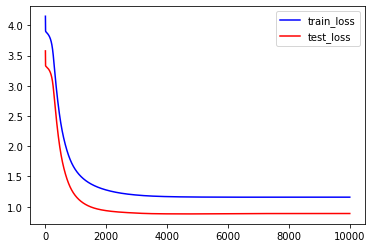

In [37]:
a = [i for i in range(10000)]
plt.plot(a, train_loss_list,label = 'train_loss', c = 'b')
plt.plot(a, test_loss_list,label = 'test_loss', c = 'r')
plt.legend()
plt.show()

# Plot the accuracy curve

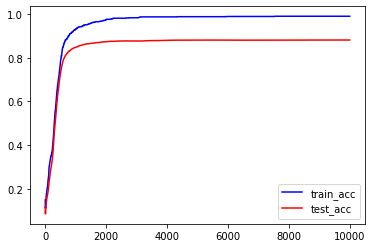

In [38]:
plt.plot(a, train_acc_list,label = 'train_acc', c = 'b')
plt.plot(a, test_acc_list,label = 'test_acc', c = 'r')
plt.legend()
plt.show()

# Plot the accuracy value

In [39]:
print("final train accuracy: {0}%".format(train_acc*100))

final train accuracy: 99.1%


In [40]:
print("final test accuracy: {0}%".format(test_acc*100))

final test accuracy: 88.2%


In [41]:
output = network.predict(x_test)
output = np.argmax(output, axis = 1)

In [42]:
correct_count = 0
incorrect_count = 0
image_idx = 0
correct_label = []
incorrect_label = []

while correct_count < 10 or incorrect_count < 10:
  if output[image_idx] == t_test[image_idx]:
    correct_count += 1
    correct_label.append(image_idx)
  else:
    incorrect_count += 1
    incorrect_label.append((image_idx, output[image_idx]))

  image_idx += 1


# 10 correctly classified testing images

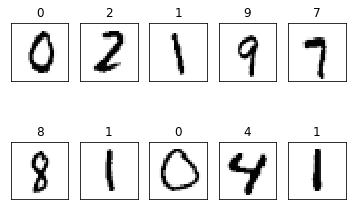

In [43]:
f1 = plt.figure(1)

for i in range(10):
      label       = t_test[correct_label[i]]
      im_vector   = x_test[correct_label[i],:]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(2, 5, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)
  

# 10 incorrectly classified testing images

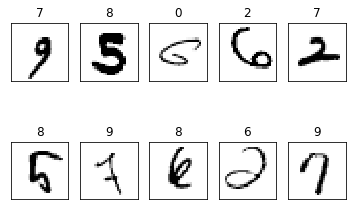

In [44]:
for i in range(10):
      label       = incorrect_label[i][1]
      im_vector   = x_test[incorrect_label[i][0],:]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(2, 5, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)